In [1]:
# A better way to read the same file, handling BOM and end-of-line truncation

import re
import pandas as pd
from pathlib import Path

path = "arrets_ben.csv"
out_parquet = "arrets_ben.parquet"

# --- 1) Read header + dash line, remove BOM automatically ---
with open(path, encoding="utf-8-sig") as f:
    header_line = f.readline().rstrip("\n")
    dash_line   = f.readline().rstrip("\n")

# --- 2) Infer column spans from runs of dashes ---
colspecs = [(m.start(), m.end()) for m in re.finditer(r"-+", dash_line)]

# Make the last column go to end-of-line to avoid truncation
colspecs[-1] = (colspecs[-1][0], None)

# --- 3) Slice column names from the (BOM-stripped) header ---
raw_names = [header_line[s:] if e is None else header_line[s:e] for s, e in colspecs]
names = []
seen = {}
for nm in map(str.strip, raw_names):
    seen[nm] = seen.get(nm, -1) + 1
    names.append(nm if seen[nm] == 0 else f"{nm}_{seen[nm]}")

print("Detected columns:", len(names))
print(names[:10], "...")

# --- 4) Read the data as fixed-width (skip header + dashes) ---
df = pd.read_fwf(
    path,
    colspecs=colspecs,
    names=names,
    skiprows=2,
    na_values=["NULL"],
    encoding="utf-8-sig",
)
print(df.shape)
print(df.head(3))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Detected columns: 73
['IdCourse', 'IdArret', 'RangArretAsc', 'DateCourse', 'HDepartTheo', 'HArriveeTheo', 'DistanceTheo', 'TempsInterArretTheo', 'EcartDepart', 'EcartDistance'] ...
(2301409, 73)
   IdCourse  IdArret  RangArretAsc  DateCourse HDepartTheo HArriveeTheo  \
0  83748979      261             1  2024-10-01    16:59:00     16:59:00   
1  83748853      261             1  2024-10-01    06:31:00     06:31:00   
2  83748927     6948             1  2024-10-01    05:07:00     05:07:00   

   D

In [2]:
# --- QC CONFIG (tunable thresholds) ---
MAX_LINK_S  = 3600     # link runtime upper bound (s) ~ 1 hour
MAX_DWELL_S = 1200     # dwell upper bound (s) ~ 20 min
AGREE_TOLS  = [5, 10, 20, 60]  # tolerances for cross-checks (seconds)
SAMPLE_N    = 30000    # for scatter plots

# --- columns to parse as datetime (only if present) ---
time_cols = [
    "DTDepartTheo","DTArriveeTheo",
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
    "DTMarquageArretTheo","DTMarquageArretReal"
]
for c in time_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Sort to make within-trip diffs meaningful
if {"IdCourse","RangArretAsc"}.issubset(df.columns):
    df = df.sort_values(["IdCourse","RangArretAsc"], kind="mergesort").reset_index(drop=True)


In [10]:
len(df)

2301409

In [3]:
import numpy as np
import pandas as pd

def basic_audit(col):
    s = df[col] if col in df.columns else pd.Series(dtype="float64")
    out = {
        "exists": col in df.columns,
        "non_null_rate": float(s.notna().mean()) if col in df.columns else 0.0
    }
    if col in df.columns:
        # For numeric-like columns, coerce to numeric to probe duplicates / ranges
        sn = pd.to_numeric(s, errors="coerce") if s.dtype.kind not in "Mm" else s
        # top repeats
        vc = s.astype(str).value_counts(dropna=True).head(5)
        out["top_values"] = vc.to_dict()
    return pd.Series(out)

cols_to_check = [
    "TempsInterArretTheo","TempsInterArretRealise","EcartDepart",
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp"
]
audit_table = pd.concat([basic_audit(c) for c in cols_to_check], axis=1).T
audit_table


,exists,non_null_rate,top_values
0,True,1.0,"{'0': 133376, '100': 132379, '140': 75998, '12..."
1,True,1.0,"{'0': 127558, '81': 31218, '82': 31037, '83': ..."
2,True,1.0,"{'6': 11438, '7': 11409, '8': 11255, '9': 1116..."
3,True,1.0,"{'2024-12-12 08:01:49': 6, '2025-02-26 17:26:4..."
4,True,1.0,"{'2024-10-14 10:37:29': 5, '2024-10-11 16:12:2..."
5,True,1.0,"{'2025-04-14 11:37:56': 6, '2025-03-20 17:37:1..."
6,True,1.0,"{'2024-12-10 18:51:22': 5, '2025-01-27 09:27:2..."


In [9]:
# window dwell at current stop
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(df.columns):
    df["dwell_window_s"] = (df["DTSortieFenetreArretReal"] - df["DTEntreeFenetreArretReal"]).dt.total_seconds()
else:
    df["dwell_window_s"] = np.nan

# window link between stops: current entry - previous exit (within IdCourse)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal","IdCourse"}.issubset(df.columns):
    df["prev_DTSortieFenetreReal"] = df.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1)
    df["link_window_s"] = (df["DTEntreeFenetreArretReal"] - df["prev_DTSortieFenetreReal"]).dt.total_seconds()
else:
    df["link_window_s"] = np.nan

# ATP link: current ATP entry - previous ATP exit
if {"DTEntreeArretAtp","DTSortieArretAtp","IdCourse"}.issubset(df.columns):
    df["prev_DTSortieAtp"] = df.groupby("IdCourse")["DTSortieArretAtp"].shift(1)
    df["link_atp_s"] = (df["DTEntreeArretAtp"] - df["prev_DTSortieAtp"]).dt.total_seconds()
else:
    df["link_atp_s"] = np.nan

# numeric versions of provided link times
df["theo_link_s"] = pd.to_numeric(df.get("TempsInterArretTheo", np.nan), errors="coerce")
df["real_link_s"] = pd.to_numeric(df.get("TempsInterArretRealise", np.nan), errors="coerce")

def qc_range_summary(s, name, upper):
    x = pd.to_numeric(s, errors="coerce")
    return pd.Series({
        "non_null_rate": float(x.notna().mean()),
        "share_neg": float((x < 0).mean(skipna=True)),
        "share_zero": float((x == 0).mean(skipna=True)),
        f"share_>{upper}s": float((x > upper).mean(skipna=True)),
        "p50": float(np.nanpercentile(x, 50)) if x.notna().any() else np.nan,
        "p95": float(np.nanpercentile(x, 95)) if x.notna().any() else np.nan,
        "p99": float(np.nanpercentile(x, 99)) if x.notna().any() else np.nan,
    }, name=name)

qc_link = pd.concat([
    qc_range_summary(df["theo_link_s"], "theo_link_s", MAX_LINK_S),
    qc_range_summary(df["real_link_s"], "real_link_s", MAX_LINK_S),
    qc_range_summary(df["link_window_s"], "link_window_s", MAX_LINK_S),
    qc_range_summary(df["link_atp_s"], "link_atp_s", MAX_LINK_S),
], axis=1).T

qc_dwell = qc_range_summary(df["dwell_window_s"], "dwell_window_s", MAX_DWELL_S).to_frame().T

qc_link, qc_dwell


(               non_null_rate  share_neg  share_zero  share_>3600s   p50  \
 theo_link_s         1.000000   0.000000    0.057954      0.000000  91.0   
 real_link_s         1.000000   0.000000    0.055426      0.000034  88.0   
 link_window_s       0.944574   0.000024    0.000268      0.000002  46.0   
 link_atp_s          0.944574   0.000040    0.000032      0.000004  85.0   
 
                  p95    p99  
 theo_link_s    175.0  227.0  
 real_link_s    192.0  288.0  
 link_window_s  130.0  208.0  
 link_atp_s     176.0  260.0  ,
                 non_null_rate  share_neg  share_zero  share_>1200s   p50  \
 dwell_window_s            1.0   0.001222    0.000597      0.000404  41.0   
 
                   p95    p99  
 dwell_window_s  113.0  542.0  )

In [5]:
violations = {}

# (A) same-stop window order: Entree <= Sortie
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(df.columns):
    bad = (df["DTSortieFenetreArretReal"] < df["DTEntreeFenetreArretReal"]).sum()
    violations["same_stop_window_order_bad"] = int(bad)

# (B) across stops (window): prev Sortie <= curr Entree
if {"prev_DTSortieFenetreReal","DTEntreeFenetreArretReal"}.issubset(df.columns):
    bad = (df["DTEntreeFenetreArretReal"] < df["prev_DTSortieFenetreReal"]).sum()
    violations["across_stops_window_nonmonotone"] = int(bad)

# (C) same-stop ATP order
if {"DTEntreeArretAtp","DTSortieArretAtp"}.issubset(df.columns):
    bad = (df["DTSortieArretAtp"] < df["DTEntreeArretAtp"]).sum()
    violations["same_stop_atp_order_bad"] = int(bad)

# (D) across stops ATP monotonicity
if {"prev_DTSortieAtp","DTEntreeArretAtp"}.issubset(df.columns):
    bad = (df["DTEntreeArretAtp"] < df["prev_DTSortieAtp"]).sum()
    violations["across_stops_atp_nonmonotone"] = int(bad)

pd.Series(violations, name="violations")

same_stop_window_order_bad         2813
across_stops_window_nonmonotone      56
same_stop_atp_order_bad             500
across_stops_atp_nonmonotone         91
Name: violations, dtype: int64

In [6]:
def pair_agreement(a, b, name):
    aa = pd.to_numeric(df[a], errors="coerce")
    bb = pd.to_numeric(df[b], errors="coerce")
    d  = (aa - bb).abs()
    out = {"n_common": int(d.notna().sum())}
    for tol in AGREE_TOLS:
        out[f"share_within_{tol}s"] = float((d <= tol).mean(skipna=True))
    out["median_abs_diff"] = float(np.nanmedian(d))
    out["p90_abs_diff"]    = float(np.nanpercentile(d, 90)) if d.notna().any() else np.nan
    return pd.Series(out, name=name)

agree_tbl = pd.concat([
    pair_agreement("link_window_s","link_atp_s", "window_vs_atp"),
    pair_agreement("link_window_s","real_link_s","window_vs_realise"),
    pair_agreement("link_window_s","theo_link_s","window_vs_theo"),
    pair_agreement("real_link_s","theo_link_s","realise_vs_theo"),
], axis=1).T

agree_tbl

,n_common,share_within_5s,share_within_10s,share_within_20s,share_within_60s,median_abs_diff,p90_abs_diff
window_vs_atp,2173850.0,0.005461,0.031193,0.174539,0.880555,35.0,55.0
window_vs_realise,2173850.0,0.001669,0.032036,0.111746,0.807303,41.0,68.0
window_vs_theo,2173850.0,0.019568,0.040898,0.131217,0.745757,42.0,74.0
realise_vs_theo,2301409.0,0.262094,0.434876,0.686910,0.945038,13.0,44.0


In [7]:
# E proxies: (window mid) and (window exit) and (ATP exit) vs DTDepartTheo
E_given = pd.to_numeric(df.get("EcartDepart", np.nan), errors="coerce")

E_from_win_mid = np.nan
E_from_win_out = np.nan
E_from_atp_out = np.nan

if {"DTDepartTheo","DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(df.columns):
    mid = df["DTEntreeFenetreArretReal"] + (df["DTSortieFenetreArretReal"] - df["DTEntreeFenetreArretReal"]) / 2
    E_from_win_mid = (mid - df["DTDepartTheo"]).dt.total_seconds()
    E_from_win_out = (df["DTSortieFenetreArretReal"] - df["DTDepartTheo"]).dt.total_seconds()

if {"DTDepartTheo","DTSortieArretAtp"}.issubset(df.columns):
    E_from_atp_out = (df["DTSortieArretAtp"] - df["DTDepartTheo"]).dt.total_seconds()

def compare_E(name, proxy):
    if isinstance(proxy, (int, float)):
        return pd.Series({"n_common": 0})
    d = (E_given - pd.to_numeric(proxy, errors="coerce")).abs()
    out = {"n_common": int(d.notna().sum()),
           "median_abs_diff": float(np.nanmedian(d))}
    for tol in AGREE_TOLS:
        out[f"share_within_{tol}s"] = float((d <= tol).mean(skipna=True))
    return pd.Series(out, name=name)

E_agree = pd.concat([
    compare_E("E_given_vs_win_mid", E_from_win_mid),
    compare_E("E_given_vs_win_out", E_from_win_out),
    compare_E("E_given_vs_atp_out", E_from_atp_out),
], axis=1).T

E_agree

,n_common,median_abs_diff,share_within_5s,share_within_10s,share_within_20s,share_within_60s
E_given_vs_win_mid,2301384.0,11.0,0.175918,0.441939,0.790474,0.962004
E_given_vs_win_out,2301384.0,10.0,0.093833,0.518744,0.703729,0.979157
E_given_vs_atp_out,2301384.0,7.0,0.375461,0.674851,0.843374,0.989888


In [ ]:
import numpy as np
import pandas as pd

# Make sure the key columns exist
need_cols = ["IdCourse","RangArretAsc","DTDepartTheo","DTEntreeArretAtp","DTSortieArretAtp"]
missing = [c for c in need_cols if c not in df.columns]
print("Missing columns:", missing)

# Parse to datetime (no cross-source fallback; just coerce)
for c in ["DTDepartTheo","DTEntreeArretAtp","DTSortieArretAtp"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Basic sort for per-trip order checks
df = df.sort_values(["IdCourse","RangArretAsc"], kind="mergesort").reset_index(drop=True)

In [11]:
cols = ["DTDepartTheo","DTEntreeArretAtp","DTSortieArretAtp"]
col_sum = []
for c in cols:
    s = df[c]
    non_null_rate = float(s.notna().mean())
    dtype = str(s.dtype)
    n_unique = s.nunique(dropna=True)
    # seconds histogram (detect rounding spikes at :00 / :30)
    sec_share = (s.dt.second.value_counts(normalize=True, dropna=True)
                   if pd.api.types.is_datetime64_any_dtype(s) else pd.Series(dtype=float))
    share_sec0  = float(sec_share.get(0, 0.0))
    share_sec30 = float(sec_share.get(30, 0.0))
    top_vals = s.value_counts(dropna=True).head(8).to_dict()  # suspicious repeated stamps

    col_sum.append(dict(
        column=c, dtype=dtype, non_null_rate=non_null_rate,
        n_unique=int(n_unique), share_sec0=share_sec0, share_sec30=share_sec30,
        top_values=top_vals
    ))

pd.DataFrame(col_sum)

,column,dtype,non_null_rate,n_unique,share_sec0,share_sec30,top_values
0,DTDepartTheo,datetime64[ns],0.999989,1698203,0.212827,0.007736,"{2024-10-21 13:30:00: 10, 2025-04-30 16:28:00:..."
1,DTEntreeArretAtp,datetime64[ns],1.000000,2129281,0.016984,0.016409,"{2025-04-14 11:37:56: 6, 2025-03-20 17:37:18: ..."
2,DTSortieArretAtp,datetime64[ns],1.000000,2132647,0.016987,0.016442,"{2024-12-10 18:51:22: 5, 2025-01-27 09:27:28: ..."


In [12]:
# Dwell = depart - arrive (ATP only)
df["dwell_atp_s"] = (df["DTSortieArretAtp"] - df["DTEntreeArretAtp"]).dt.total_seconds()

order_checks = pd.DataFrame({
    "non_null_rate_dwell": df["dwell_atp_s"].notna().mean(),
    "share_negative_dwell": (df["dwell_atp_s"] < 0).mean(),
    "share_zero_dwell": (df["dwell_atp_s"] == 0).mean(),
    "p50_dwell": np.nanpercentile(df["dwell_atp_s"], 50),
    "p95_dwell": np.nanpercentile(df["dwell_atp_s"], 95),
    "p99_dwell": np.nanpercentile(df["dwell_atp_s"], 99)
}, index=[0])
order_checks

,non_null_rate_dwell,share_negative_dwell,share_zero_dwell,p50_dwell,p95_dwell,p99_dwell
0,1.0,0.000217,0.341907,3.0,42.0,345.0


In [14]:
# Prev stamps (shift within trip)
df["prev_DTEntreeArretAtp"] = df.groupby("IdCourse")["DTEntreeArretAtp"].shift(1)
df["prev_DTSortieArretAtp"] = df.groupby("IdCourse")["DTSortieArretAtp"].shift(1)
df["prev_DTDepartTheo"]     = df.groupby("IdCourse")["DTDepartTheo"].shift(1)

# Pure run between stops (no dwell on either side): arrive(curr) - depart(prev)
df["run_atp_s"] = (df["DTEntreeArretAtp"] - df["prev_DTSortieArretAtp"]).dt.total_seconds()
# Depart-to-depart spacing (includes current dwell)
df["dep2dep_atp_s"] = (df["DTSortieArretAtp"] - df["prev_DTSortieArretAtp"]).dt.total_seconds()
# Scheduled depart-to-depart spacing
df["dep2dep_theo_s"] = (df["DTDepartTheo"] - df["prev_DTDepartTheo"]).dt.total_seconds()

# Flag rules (tune thresholds to your context)
viol = pd.DataFrame(index=df.index)
viol["run_neg"]     = df["run_atp_s"] < 0                  # time travel
viol["dep2dep_neg"] = df["dep2dep_atp_s"] < 0             # depart goes backwards
viol["dwell_neg"]   = df["dwell_atp_s"] < 0
viol["run_too_big"] = df["run_atp_s"] > 3600              # >1h pure run between adjacent stops
viol["dep2dep_big"] = df["dep2dep_atp_s"] > 5400          # >1.5h depart-to-depart
viol["sched_back"]  = df["dep2dep_theo_s"] < 0            # schedule not increasing

summary = pd.DataFrame({
    "share_run_neg": viol["run_neg"].mean(),
    "share_dep2dep_neg": viol["dep2dep_neg"].mean(),
    "share_dwell_neg": viol["dwell_neg"].mean(),
    "share_run>3600s": viol["run_too_big"].mean(),
    "share_dep2dep>5400s": viol["dep2dep_big"].mean(),
    "share_sched_back": viol["sched_back"].mean()
}, index=[0])
summary

,share_run_neg,share_dep2dep_neg,share_dwell_neg,share_run>3600s,share_dep2dep>5400s,share_sched_back
0,0.00004,0.000025,0.000217,0.000004,4.345164e-07,0.002927


In [16]:
df["E_star"] = (df["DTSortieArretAtp"] - df["DTDepartTheo"]).dt.total_seconds()

E_stats = pd.DataFrame({
    "non_null_rate": df["E_star"].notna().mean(),
    "p50": np.nanpercentile(df["E_star"], 50),
    "p90": np.nanpercentile(df["E_star"], 90),
    "p95": np.nanpercentile(df["E_star"], 95),
    "p99": np.nanpercentile(df["E_star"], 99),
    "p01": np.nanpercentile(df["E_star"], 1),
    "p05": np.nanpercentile(df["E_star"], 5)
}, index=[0])
E_stats

,non_null_rate,p50,p90,p95,p99,p01,p05
0,0.999989,48.0,246.0,355.0,771.0,-165.0,-91.0


In [17]:
# Heavy repeats of exact E* (e.g., rounding to fixed offsets)
E_top = df["E_star"].round().value_counts().head(10)
print("Top repeated E* (rounded to 1s):")
display(E_top)

Top repeated E* (rounded to 1s):


E_star
13.0    10775
1.0     10714
2.0     10652
18.0    10651
11.0    10642
5.0     10631
10.0    10613
15.0    10606
8.0     10601
12.0    10589
Name: count, dtype: int64

In [19]:
# Zero-dwell flag (ATP source only)
df["dwell_atp_s"] = (df["DTSortieArretAtp"] - df["DTEntreeArretAtp"]).dt.total_seconds()
df["zero_dwell"]  = df["dwell_atp_s"]==0

# Doors-open signals if you have them (use whichever exists)
has_doors_cols = [c for c in ["HOuverturePortesReal","HFermetureportesReal",
                              "DTOuverturePortes","DTFermeturesPortes"] if c in df.columns]
for c in has_doors_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

df["doors_open"] = False
if {"DTOuverturePortes","DTFermeturesPortes"}.issubset(df.columns):
    df["doors_open"] |= df["DTOuverturePortes"].notna() & df["DTFermeturesPortes"].notna()
if {"HOuverturePortesReal","HFermetureportesReal"}.issubset(df.columns):
    df["doors_open"] |= df["HOuverturePortesReal"].notna() & df["HFermetureportesReal"].notna()

# Service evidence from counts (if present)
for c in ["NbMontees","NbDescentes"]:
    if c in df.columns: df[c]=pd.to_numeric(df[c], errors="coerce")
df["had_activity"] = ((df.get("NbMontees",0).fillna(0) + df.get("NbDescentes",0).fillna(0))>0)

# Exact-equal timestamps (suggests logging/rounding)
df["arr_eq_dep_exact"] = df["DTEntreeArretAtp"].notna() & (df["DTEntreeArretAtp"]==df["DTSortieArretAtp"])

# Breakdown table
chk = (df.groupby(["zero_dwell","doors_open","had_activity","arr_eq_dep_exact"])
         .size().rename("rows").reset_index())
chk["share"] = chk["rows"]/len(df)
chk.sort_values("rows", ascending=False).head(12)

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_56830/2768386839.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_56830/2768386839.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")


,zero_dwell,doors_open,had_activity,arr_eq_dep_exact,rows,share
3,False,True,True,False,1381435,0.600256
7,True,True,True,True,439776,0.191090
4,True,False,False,True,237580,0.103232
2,False,True,False,False,82449,0.035825
5,True,False,True,True,61796,0.026851
6,True,True,False,True,47715,0.020733
0,False,False,False,False,29033,0.012615
1,False,False,True,False,21625,0.009396


In [20]:
# Make sure these columns exist as datetimes
for c in ["DTEntreeArretAtp","DTSortieArretAtp",
          "DTOuverturePortes","DTFermeturesPortes",
          "HOuverturePortesReal","HFermetureportesReal",
          "DTDepartTheo"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Basic ids as strings where helpful
if "C_Ligne" in df.columns:
    df["C_Ligne"] = pd.to_numeric(df["C_Ligne"], errors="coerce")
if "CodeLong" in df.columns:
    df["CodeLong"] = df["CodeLong"].astype(str).str.strip()

# Compute ATP dwell in seconds (rounded to nearest second for “same-second” detection)
df["dwell_atp_sec"] = (df["DTSortieArretAtp"] - df["DTEntreeArretAtp"]).dt.total_seconds()
df["dwell_atp_sec_int"] = pd.to_numeric(df["dwell_atp_sec"], errors="coerce").round().astype("Int64")

# Flags for exactly same-second & 1-second cases
df["atp_same_second"] = (df["dwell_atp_sec_int"] == 0)
df["atp_one_second"]  = (df["dwell_atp_sec_int"] == 1)

# Sanity: negative or huge dwell (likely logging issues)
df["atp_dwell_negative"] = df["dwell_atp_sec_int"].notna() & (df["dwell_atp_sec_int"] < 0)
df["atp_dwell_gt_10min"] = df["dwell_atp_sec_int"].notna() & (df["dwell_atp_sec_int"] > 600)

In [21]:
tot = df["dwell_atp_sec_int"].notna().sum()
summary = pd.DataFrame({
    "share_same_second": [float((df["atp_same_second"]).mean())],
    "share_one_second":  [float((df["atp_one_second"]).mean())],
    "share_le2_seconds": [float((df["dwell_atp_sec_int"].isin([0,1,2])).mean())],
    "median_dwell_s":    [float(df["dwell_atp_sec"].median())],
    "p90_dwell_s":       [float(df["dwell_atp_sec"].quantile(0.90))],
    "p99_dwell_s":       [float(df["dwell_atp_sec"].quantile(0.99))],
    "share_negative":    [float(df["atp_dwell_negative"].mean())],
    "share_gt_10min":    [float(df["atp_dwell_gt_10min"].mean())],
    "n_rows_with_dwell": [int(tot)]
})
summary

,share_same_second,share_one_second,share_le2_seconds,median_dwell_s,p90_dwell_s,p99_dwell_s,share_negative,share_gt_10min,n_rows_with_dwell
0,0.341907,0.113793,0.482053,3.0,25.0,345.0,0.000217,0.002604,2301409


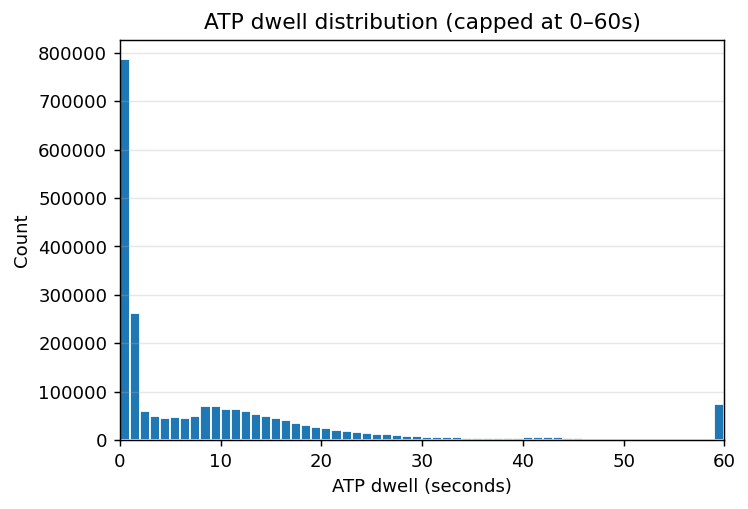

In [22]:
import numpy as np, matplotlib.pyplot as plt

x = df["dwell_atp_sec"].clip(lower=0, upper=60).dropna()
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(x, bins=np.arange(0, 61, 1), edgecolor="white")
ax.set_title("ATP dwell distribution (capped at 0–60s)")
ax.set_xlabel("ATP dwell (seconds)")
ax.set_ylabel("Count")
ax.set_xlim(0,60)
ax.grid(True, axis="y", alpha=0.3)
plt.show()

In [23]:
# By line (top lines with highest same-second or one-second shares)
if "C_Ligne" in df.columns:
    line_tbl = (df.groupby("C_Ligne")[["atp_same_second","atp_one_second"]]
                  .mean().rename(columns={"atp_same_second":"share_0s",
                                          "atp_one_second":"share_1s"})
                  .reset_index())
    line_tbl = line_tbl.merge(df["C_Ligne"].value_counts().rename("n").reset_index()
                                  .rename(columns={"index":"C_Ligne"}),
                              on="C_Ligne")
    line_tbl = line_tbl.sort_values(["share_0s","share_1s","n"], ascending=[False,False,False])
    line_tbl.head(15)

# By stop (require sufficient samples, say n>=500)
if "CodeLong" in df.columns:
    stop_counts = df["CodeLong"].value_counts()
    good_stops = stop_counts[stop_counts>=500].index
    stop_tbl = (df[df["CodeLong"].isin(good_stops)]
                .groupby("CodeLong")[["atp_same_second","atp_one_second"]]
                .mean().rename(columns={"atp_same_second":"share_0s",
                                        "atp_one_second":"share_1s"})
                .reset_index()
                .merge(stop_counts.rename("n").reset_index().rename(columns={"index":"CodeLong"}),
                       on="CodeLong")
                .sort_values(["share_0s","share_1s","n"], ascending=[False,False,False]))
    stop_tbl.head(20)

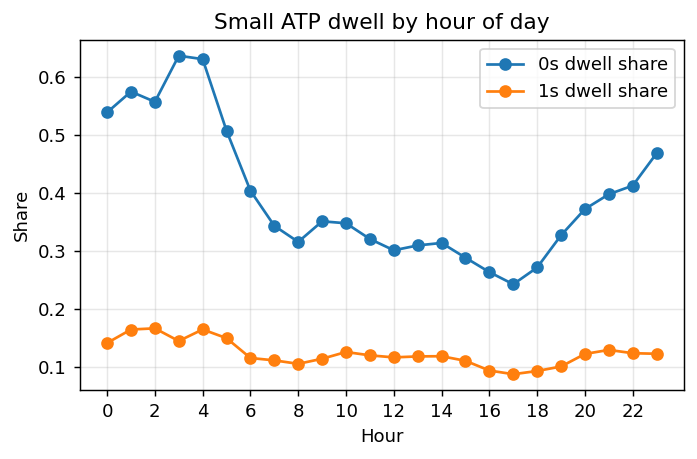

In [24]:
df["hour_atp"] = df["DTEntreeArretAtp"].dt.hour
hod = (df.dropna(subset=["hour_atp"])
         .groupby("hour_atp")[["atp_same_second","atp_one_second"]]
         .mean().rename(columns={"atp_same_second":"share_0s",
                                 "atp_one_second":"share_1s"})
         .reset_index())

fig, ax = plt.subplots(figsize=(6,3.5))
ax.plot(hod["hour_atp"], hod["share_0s"], marker="o", label="0s dwell share")
ax.plot(hod["hour_atp"], hod["share_1s"], marker="o", label="1s dwell share")
ax.set_title("Small ATP dwell by hour of day")
ax.set_xlabel("Hour")
ax.set_ylabel("Share")
ax.set_xticks(range(0,24,2))
ax.grid(True, axis="both", alpha=0.3)
ax.legend()
plt.show()

In [26]:
# Doors opened?
df["doors_open"] = False
if {"DTOuverturePortes","DTFermeturesPortes"}.issubset(df.columns):
    df["doors_open"] |= df["DTOuverturePortes"].notna() & df["DTFermeturesPortes"].notna()
if {"HOuverturePortesReal","HFermetureportesReal"}.issubset(df.columns):
    df["doors_open"] |= df["HOuverturePortesReal"].notna() & df["HFermetureportesReal"].notna()

# Pax activity?
for c in ["NbMontees","NbDescentes"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
df["had_activity"] = ((df.get("NbMontees",0).fillna(0) + df.get("NbDescentes",0).fillna(0))>0)

# How many “0–1s” dwell still show doors or activity? -> suspicious
small = df["dwell_atp_sec_int"].isin([0,1])
chk_small = (df.loc[small]
             .assign(suspicious = df.loc[small, "doors_open"] | df.loc[small, "had_activity"] )
             .agg({"suspicious":"mean"}))
float(chk_small["suspicious"])

0.7734562350834469

In [25]:
# Sort within trip
df = df.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")

# Entry/exit should be non-decreasing within the trip
df["prev_DTSortieAtp"] = df.groupby("IdCourse")["DTSortieArretAtp"].shift(1)
df["prev_DTEntreeAtp"] = df.groupby("IdCourse")["DTEntreeArretAtp"].shift(1)

viol_same_stop = (df["DTSortieArretAtp"] < df["DTEntreeArretAtp"]).sum()
viol_across_stops = (df["DTEntreeArretAtp"] < df["prev_DTSortieAtp"]).sum()

print({"viol_same_stop_exit_before_entry": int(viol_same_stop),
       "viol_across_stops_curr_entry_before_prev_exit": int(viol_across_stops)})

{'viol_same_stop_exit_before_entry': 500, 'viol_across_stops_curr_entry_before_prev_exit': 91}


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


need = ["DTEntreeFenetreArretReal","DTSortieFenetreArretReal"]
print({c: (c in df.columns) for c in need})

for c in need + ["DTOuverturePortes","DTFermeturesPortes"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df["dwell_window_s"] = (
    df["DTSortieFenetreArretReal"] - df["DTEntreeFenetreArretReal"]
).dt.total_seconds()

N = len(df)
s = df["dwell_window_s"]
print("non_null_rate =", s.notna().mean())
print("share_neg     =", (s < 0).mean())
print("share_zero    =", (s == 0).mean())
print("share_le_1s   =", (s.between(0,1)).mean())
print("p50/p95/p99   =", np.nanpercentile(s, [50,95,99]))
print("share_gt_600s =", (s > 600).mean())

{'DTEntreeFenetreArretReal': True, 'DTSortieFenetreArretReal': True}
non_null_rate = 1.0
share_neg     = 0.0012222946899051843
share_zero    = 0.0005970255612974487
share_le_1s   = 0.0013821967325234237
p50/p95/p99   = [ 41. 113. 542.]
share_gt_600s = 0.007441528211630353


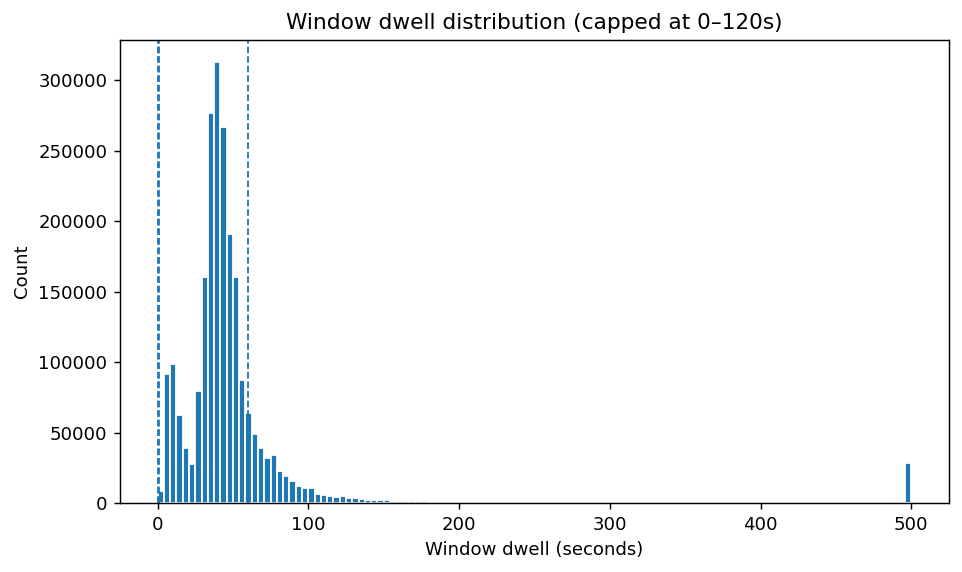

In [32]:
s = df["dwell_window_s"].dropna().clip(0, 500)

plt.figure(figsize=(7.5,4.5))
plt.hist(s, bins=120, edgecolor="white")
plt.title("Window dwell distribution (capped at 0–120s)")
plt.xlabel("Window dwell (seconds)")
plt.ylabel("Count")
for v in [0,1,60]:
    plt.axvline(v, ls="--", lw=1)
plt.tight_layout()
plt.show()

In [33]:
# 需要 IdCourse 與 RangArretAsc 才能做順序檢查
if {"IdCourse","RangArretAsc"}.issubset(df.columns):
    g = df.sort_values(["IdCourse","RangArretAsc"])

    # 同一站：window-out 應該 >= window-in（負值/顛倒次序偵測）
    bad_same_stop = (g["DTSortieFenetreArretReal"] < g["DTEntreeFenetreArretReal"]).sum()

    # 跨站：下一站的 window-in 應 >= 前一站的 window-out（非單調偵測）
    g["prev_out"]  = g.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1)
    g["curr_in"]   = g["DTEntreeFenetreArretReal"]
    bad_cross_stop = (
        (g["curr_in"].notna() & g["prev_out"].notna())
        & (g["curr_in"] < g["prev_out"])
    ).sum()

    print("same_stop_window_order_bad   =", bad_same_stop)
    print("across_stops_window_nonmono  =", bad_cross_stop)
else:
    print("⚠️  Skip order checks: need IdCourse & RangArretAsc")

same_stop_window_order_bad   = 2813
across_stops_window_nonmono  = 56


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 安全轉型
for c in ["DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
          "DTEntreeArretAtp","DTSortieArretAtp"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# 數值欄位安全轉型
for c in ["TempsInterArretRealise","TempsInterArretTheo",
          "DistanceInterArret","DistanceTheo","NbMontees","NbDescentes"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 行別
if "C_Ligne" in df.columns:
    df["C_Ligne"] = df["C_Ligne"].astype(str)

# 排序，之後算 window/ATP link 會用到「上一站」
if {"IdCourse","RangArretAsc"}.issubset(df.columns):
    df = df.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
else:
    print("⚠️  缺 IdCourse/RangArretAsc，無法計算 window/ATP 連站時間")

In [35]:
s = df["TempsInterArretRealise"]
N = len(df)

print("exists         :", "TempsInterArretRealise" in df.columns)
print("non_null_rate  :", float(s.notna().mean()))
print("share_neg      :", float((s < 0).mean()))
print("share_zero     :", float((s == 0).mean()))
print("share_>3600s   :", float((s > 3600).mean()))
print("p50/p95/p99    :", tuple(np.nanpercentile(s, [50,95,99])))

# 整秒「堆積」偵測（0/1/60 等）
s_int = s.dropna().round().astype(int)
focus_vals = [0,1,2,3,4,5,30,60,90,120,180]
share_focus = {v: float((s_int==v).mean()) for v in focus_vals}
top10 = s_int.value_counts().head(10).sort_index()

print("\nTop integer seconds (count):\n", top10)
print("\nShares at {0,1,2,3,4,5,30,60,90,120,180}:\n", share_focus)

exists         : True
non_null_rate  : 1.0
share_neg      : 0.0
share_zero     : 0.055426045522547276
share_>3600s   : 3.3892280772344244e-05
p50/p95/p99    : (88.0, 192.0, 288.0)

Top integer seconds (count):
 TempsInterArretRealise
0     127558
78     30191
79     30368
80     30704
81     31218
82     31037
83     30979
84     30836
85     30587
86     29912
Name: count, dtype: int64

Shares at {0,1,2,3,4,5,30,60,90,120,180}:
 {0: 0.055426045522547276, 1: 8.690328403165191e-07, 2: 4.3451642015825957e-07, 3: 7.386779142690412e-06, 4: 1.5208074705539085e-05, 5: 1.7815173226488642e-05, 30: 0.0019344671025445716, 60: 0.005758646116357414, 90: 0.012535798721565789, 120: 0.004717110257238066, 180: 0.0014182615953965592}


In [36]:
# 建「上一站」時間，用於 window/ATP link
if {"IdCourse","RangArretAsc"}.issubset(df.columns):
    df["prev_win_out"] = df.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1)
    df["prev_atp_out"] = df.groupby("IdCourse")["DTSortieArretAtp"].shift(1)

    # link（秒）
    link_window_s = (df["DTEntreeFenetreArretReal"] - df["prev_win_out"]).dt.total_seconds()
    link_atp_s    = (df["DTEntreeArretAtp"]        - df["prev_atp_out"]).dt.total_seconds()

    cmp = pd.DataFrame({
        "real": df["TempsInterArretRealise"],
        "win":  link_window_s if "DTEntreeFenetreArretReal" in df and "prev_win_out" in df else np.nan,
        "atp":  link_atp_s    if "DTEntreeArretAtp" in df and "prev_atp_out" in df else np.nan,
        "theo": df.get("TempsInterArretTheo", np.nan)
    })

    # 對各種來源計算 |差| 與 within-k 秒占比
    def quality_against(col):
        sub = cmp[["real", col]].dropna()
        if len(sub)==0:
            return pd.Series({"n_common":0})
        diff = (sub["real"] - sub[col]).abs().values
        out = {
            "n_common": len(sub),
            "median_abs_diff": float(np.median(diff)),
            "p90_abs_diff": float(np.percentile(diff, 90)),
        }
        for k in [5,10,20,60]:
            out[f"share_within_{k}s"] = float((diff <= k).mean())
        return pd.Series(out)

    print("\n=== Agreement of TempsInterArretRealise vs others ===")
    for other in ["win","atp","theo"]:
        q = quality_against(other)
        print(f"\nreal_vs_{other}:\n{q}")
else:
    print("⚠️  缺 IdCourse/RangArretAsc，跳過 window/ATP 對照")


=== Agreement of TempsInterArretRealise vs others ===

real_vs_win:
n_common            2.173850e+06
median_abs_diff     4.100000e+01
p90_abs_diff        6.800000e+01
share_within_5s     1.767371e-03
share_within_10s    3.391586e-02
share_within_20s    1.183030e-01
share_within_60s    8.546744e-01
dtype: float64

real_vs_atp:
n_common            2.173850e+06
median_abs_diff     7.000000e+00
p90_abs_diff        2.600000e+01
share_within_5s     4.271067e-01
share_within_10s    6.237500e-01
share_within_20s    8.456416e-01
share_within_60s    9.792897e-01
dtype: float64

real_vs_theo:
n_common            2.301409e+06
median_abs_diff     1.300000e+01
p90_abs_diff        4.400000e+01
share_within_5s     2.620938e-01
share_within_10s    4.348758e-01
share_within_20s    6.869096e-01
share_within_60s    9.450376e-01
dtype: float64


In [37]:
# 擇一距離欄位
dist = df.get("DistanceInterArret")
if dist is None or dist.isna().all():
    dist = df.get("DistanceTheo")
dist = pd.to_numeric(dist, errors="coerce")

# 速度（km/h）；為避免窗區 ~70m 影響，亦可試 dist-70
speed_kmh = 3.6 * dist / df["TempsInterArretRealise"]
spd = speed_kmh.replace([np.inf,-np.inf], np.nan)

print("speed p50/p95/p99 (km/h):", tuple(np.nanpercentile(spd.dropna(), [50,95,99])))
print("share_speed>120 km/h    :", float((spd > 120).mean()))  # 明顯不合理
print("share_speed<2 km/h      :", float((spd < 2).mean()))    # 幾近停滯（含塞車或量測問題） 

speed p50/p95/p99 (km/h): (16.464705882352945, 30.897391304347828, 39.90945812807882)
share_speed>120 km/h    : 0.000170764953122196
share_speed<2 km/h      : 0.002366376424181882


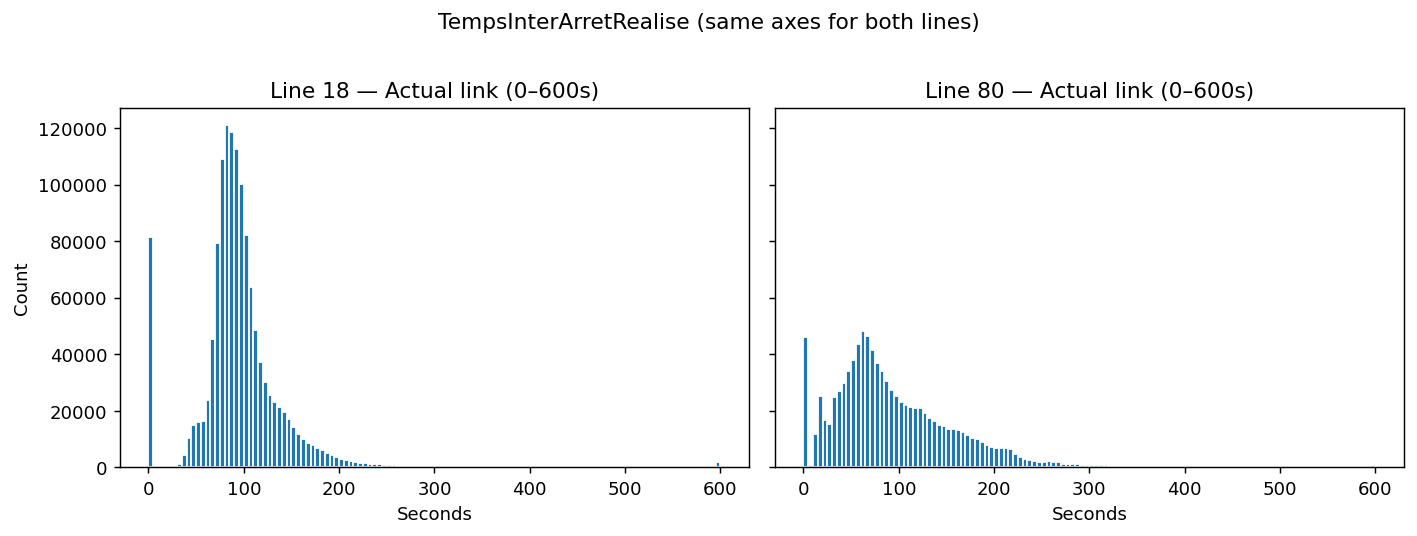

In [38]:
subset = df[df["TempsInterArretRealise"].notna()].copy()
subset["line"] = df.get("C_Ligne","?").astype(str)

# 我們只畫 0–600s
vals18 = subset.loc[subset["line"]=="18","TempsInterArretRealise"].clip(0,600)
vals80 = subset.loc[subset["line"]=="80","TempsInterArretRealise"].clip(0,600)

xmin, xmax = 0, 600
bins = np.arange(xmin, xmax+5, 5)  # 5s bins

fig, axes = plt.subplots(1, 2, figsize=(11,4), sharex=True, sharey=True)
axes[0].hist(vals18, bins=bins, edgecolor="white")
axes[0].set_title("Line 18 — Actual link (0–600s)")
axes[0].set_xlabel("Seconds"); axes[0].set_ylabel("Count")
axes[1].hist(vals80, bins=bins, edgecolor="white")
axes[1].set_title("Line 80 — Actual link (0–600s)")
axes[1].set_xlabel("Seconds")
fig.suptitle("TempsInterArretRealise (same axes for both lines)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

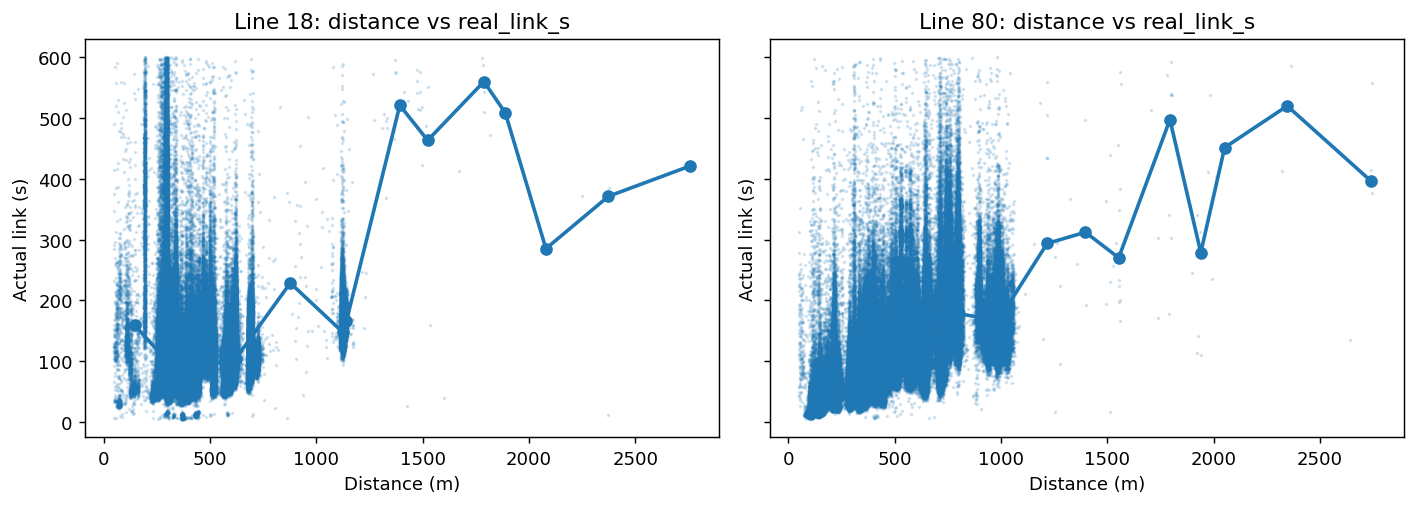

In [39]:
dist = df.get("DistanceInterArret")
if dist is None or dist.isna().all():
    dist = df.get("DistanceTheo")
dist = pd.to_numeric(dist, errors="coerce")

tmp = pd.DataFrame({
    "line": df.get("C_Ligne","?").astype(str),
    "d_m": dist,
    "t_s": df["TempsInterArretRealise"]
}).dropna()

# 合理範圍以避免極端值影響視覺
tmp = tmp[(tmp["t_s"].between(5, 600)) & (tmp["d_m"].between(50, 3000))]

# binned median
bins = np.linspace(tmp["d_m"].min(), tmp["d_m"].max(), 16)
def binned_med(x):
    x = x.copy()
    x["bin"] = np.digitize(x["d_m"], bins)
    return x.groupby("bin", group_keys=False).agg(
        d_m=("d_m","median"),
        t_s=("t_s","median"),
        n=("t_s","size")
    ).reset_index(drop=True)

m18 = binned_med(tmp[tmp["line"]=="18"])
m80 = binned_med(tmp[tmp["line"]=="80"])

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True)
for ax, data, title in [(axes[0], m18, "Line 18"), (axes[1], m80, "Line 80")]:
    ax.scatter(tmp[tmp["line"]==title.split()[-1]]["d_m"],
               tmp[tmp["line"]==title.split()[-1]]["t_s"],
               s=1, alpha=0.15)
    ax.plot(data["d_m"], data["t_s"], lw=2, marker="o")
    ax.set_title(f"{title}: distance vs real_link_s")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Actual link (s)")
plt.tight_layout()
plt.show()